# True Impact Shot Charting -- Full Sample

This notebook drives the full stat generation on a player and team level, creating all required hexmaps/Voroni diagrams/etc. from scratch. It has fewer steps and less instructions than the example, and will also take considerably more time. Only run this if you are interested in the full results.

### 1. Load the data, extract and classify shot/rebound regions

In [15]:
# Each source file has a dedicated processor class, use these to load and process src data
event_df = EventProcessor.load_games()
tracking_df = TrackingProcessor.load_games()
possession_df = PossessionProcessor.load_games()

# First, we need to extract all the shot events, link the corresponding rebound event, and associate with coordinate data
shot_rebound_df = ActionProcessor.extract_shots_and_rebounds(event_df, tracking_df)

# Now that we have the shot/rebounds collected, we can use our FeatureUtil to engineer the regions, shots are classified by which polygon contains them
shot_rebound_classified_df = FeatureUtil.classify_shot_locations(shot_rebound_df, possession_df, FeatureUtil.classify_shot_region)

# We use hexbin plots to create probabilty mappings for rebounds based on where the shot originates from
hexbin_region_data_df = StatsUtil.generate_region_hexbin_data(shot_rebound_classified_df, ShotRegionUtil.regions)

In [8]:
print(shot_rebound_classified_df)

          gameId eventType playerId          playerName      teamId teamAbbr  \
0     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
1     0022300451      SHOT   203944       Julius Randle  1610612752      NYK   
2     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
3     0022300451      SHOT  1630183     Jaden McDaniels  1610612750      MIN   
4     0022300451      SHOT  1628384          OG Anunoby  1610612752      NYK   
...          ...       ...      ...                 ...         ...      ...   
1872  0022300869      SHOT      NaN       Rui Hachimura  1610612747      LAL   
1873  0022300869      SHOT      NaN       Anthony Davis  1610612747      LAL   
1874  0022300869      SHOT      NaN        LeBron James  1610612747      LAL   
1875  0022300869      SHOT      NaN        Jamal Murray  1610612743      DEN   
1876  0022300869      SHOT      NaN       Austin Reaves  1610612747      LAL   

      period      shot_time  wcTimeEnd 

### 2. Apply the rebound projection model

In [10]:
# We then leverage vectorization to apply this procedure to all of our missed shot events, and assign the projections to the classified df
# NOTE: This step is computationally expensive, and can take a while to complete depending on your machine and the number of games
reb_chances_df = StatsUtil.assign_rebound_chances_to_shots(shot_rebound_classified_df, tracking_df, hexbin_region_data_df)
reb_chances_df.to_csv('./reb_chances.csv')
# Now we can calculate some statistics for each metric accross the various regions
FeatureUtil.calculate_rebound_statistics_by_region(reb_chances_df)
reb_chances_df.to_csv('./reb_chances.csv')


({'1629008': 0.24937655860349126, '203932': 3.4912718204488775, '203999': 0.997506234413965, '203200': 2.9925187032418954, '1627750': 0.997506234413965, '2544': 4.738154613466334, '203076': 1.2468827930174564, '1630559': 5.985037406483791, '1629060': 73.31670822942642, '1626156': 5.985037406483791}, {'1610612743': 8.728179551122196, '1610612747': 91.2718204488778})


100%|██████████| 1877/1877 [55:46<00:00,  1.78s/it]  


,shot_classification,shots_attempted,off_reb_chance_avg,def_reb_chance_avg,off_rebounds_percent_real,def_rebounds_percent_real
0,BEYOND_HALFCOURT,4.0,3.034280,3.034280,100.000000,0.000000
1,CENTER_THREE,143.0,9.452882,68.544666,27.659574,72.340426
2,CLOSE_RANGE,829.0,31.212413,54.775345,37.535014,62.464986
3,LEFT_BASELINE_MID,137.0,17.845636,65.831559,23.809524,76.190476
4,LEFT_CORNER_THREE,84.0,18.193991,64.946617,28.260870,71.739130
5,LEFT_ELBOW_MID,70.0,20.172377,67.544104,29.545455,70.454545
6,LEFT_WING_THREE,145.0,15.955027,67.625826,26.373626,73.626374
7,RIGHT_BASELINE_MID,108.0,16.526102,69.717170,22.641509,77.358491
8,RIGHT_CORNER_THREE,89.0,22.161618,65.554406,31.372549,68.627451
9,RIGHT_ELBOW_MID,88.0,17.550992,69.985157,23.076923,76.923077


### 3. Collect model statitistics

0.07676917955780432


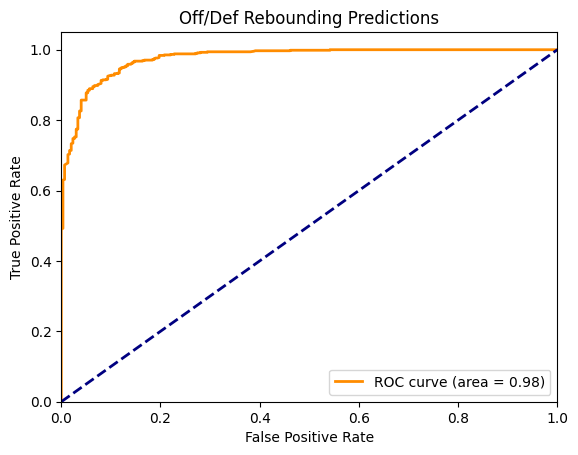

In [16]:
# First, pull off just the misses (as makes don't have projections)
misses = reb_chances_df.loc[reb_chances_df['made'] == False]

# Next, create a brier score. This indicates how much of the variance is unexplained by the model (lower is better)
print(FeatureUtil.calculate_brier_score_loss(misses))

# Finally, plot the area under the curve, which indicates the learning potential of our model (closer to 1.0 is better)
VisUtil.plot_auc(misses['dReb'], misses['def_reb_chance'], "Off/Def Rebounding Predictions")

### 4. Calculate Rebound Rate Over Expected

In [18]:

# First assign each player's rebounding odds to each missed fga
shot_data_with_chances = StatsUtil.assign_player_rebound_chances_to_shots(
    shot_rebound_classified_df,
    tracking_df, 
    hexbin_region_data_df
)

# Then aggregate accross players to assemble the rebounding projections and percentages
player_rebound_stats = FeatureUtil.calculate_player_rebound_statistics(shot_data_with_chances)

# Finally, we can take a look at the results! Will pull back player names for display
player_data = pd.read_csv("./data/src/basic_player_info.csv", header=0)
player_rebound_stats['player_id'] = player_rebound_stats['player_id'].astype(int)
player_rebound_stats = pd.merge(player_rebound_stats, player_data[["person_id", "position"]], left_on="player_id", right_on="person_id", how="left")
player_rebound_stats = player_rebound_stats.drop(columns=["person_id"], axis=1)

# NOTE: positive/negative reb above percentage values indicate that player that is over/under performing expectations
VisUtil.plot_rebounds_above_expected(player_rebound_stats)

  1%|          | 6/836 [00:09<21:10,  1.53s/it]


KeyboardInterrupt: 

### 5. Calculate true impact points

In [37]:
# To calculate true points, we augment the provided ptsProduced col by scanning for free throw sequences folowing fouls
# Any points scored from the line are assigned to the inital shot attempt, and these projections can be used as the base ppp for our model
import pandas as pd
reb_chances_df = pd.read_csv('./reb_chances.csv')
shot_rebound_classified_df = shot_rebound_classified_df.copy()
event_df = EventProcessor.load_games()
true_points_df = StatsUtil.calculate_true_points(event_df)
true_points_df['true_points_produced'].value_counts()

# First, pull off rebounds off event_df, then establish points per possession on the follow up attempts
off_rebounds_df = EventProcessor.extract_off_rebounds(event_df)
oreb_ppp = FeatureUtil.calculate_oreb_ppp(event_df, off_rebounds_df)

true_points_df.to_csv('./test.csv')
true_points_df['playerId'] = true_points_df['playerId'].astype(pd.Int64Dtype())
true_points_df['gameId'] = true_points_df['gameId'].astype(pd.Int64Dtype())
# Now we can apply that to the entire dataframe, and merge it back into our classified shot/rebound data
true_impact_points_df = StatsUtil.assign_oreb_expected_points_to_shots(true_points_df, reb_chances_df, oreb_ppp=oreb_ppp)



shot_rebound_classified_df = shot_rebound_classified_df.rename(columns={"shot_time": "wcTime"})
shot_rebound_classified_df['playerId'] = shot_rebound_classified_df['playerId'].astype(pd.Int64Dtype())
shot_rebound_classified_df['gameId'] = shot_rebound_classified_df['gameId'].astype(pd.Int64Dtype())

print(len(true_impact_points_df), len(shot_rebound_classified_df))
true_impact_points_df = true_impact_points_df.merge(
    shot_rebound_classified_df[['gameId', 'gcTime', 'shot_x', 'shot_y', 'rebound_x', 'rebound_y', 'shot_classification']],
    on=['gameId', 'gcTime'],
    how='left'
)

# Let's see how expectations shift accross the different metrics
print(shot_rebound_classified_df)
print(true_impact_points_df)
true_impact_points_df.to_csv('./data/results/true_impact_points_df.csv')

shot_statistics_by_region = FeatureUtil.calculate_shot_statistics_by_region(true_impact_points_df)
FeatureUtil.calculate_net_gains(shot_statistics_by_region)
shot_statistics_by_region.to_csv('./test_final.csv')

# Assuming your data is in a DataFrame called 'df'
pivot_table = true_impact_points_df.groupby('shot_classification').agg({
    'points_produced': 'mean',
    'true_points_produced': 'mean',
    'true_impact_points_produced': 'mean'
}).reset_index()
print(pivot_table)

1958 1877
        gameId eventType  playerId          playerName      teamId teamAbbr  \
0     22300451      SHOT   1626157  Karl-Anthony Towns  1610612750      MIN   
1     22300451      SHOT    203944       Julius Randle  1610612752      NYK   
2     22300451      SHOT   1626157  Karl-Anthony Towns  1610612750      MIN   
3     22300451      SHOT   1630183     Jaden McDaniels  1610612750      MIN   
4     22300451      SHOT   1628384          OG Anunoby  1610612752      NYK   
...        ...       ...       ...                 ...         ...      ...   
1872  22300869      SHOT      <NA>       Rui Hachimura  1610612747      LAL   
1873  22300869      SHOT      <NA>       Anthony Davis  1610612747      LAL   
1874  22300869      SHOT      <NA>        LeBron James  1610612747      LAL   
1875  22300869      SHOT      <NA>        Jamal Murray  1610612743      DEN   
1876  22300869      SHOT      <NA>       Austin Reaves  1610612747      LAL   

      period         wcTime  wcTimeEnd  g

### 6. Generate shot charts

          gameId eventType playerId          playerName      teamId teamAbbr  \
0     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
1     0022300451      SHOT   203944       Julius Randle  1610612752      NYK   
2     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
3     0022300451      SHOT  1630183     Jaden McDaniels  1610612750      MIN   
4     0022300451      SHOT  1628384          OG Anunoby  1610612752      NYK   
...          ...       ...      ...                 ...         ...      ...   
1872  0022300869      SHOT      NaN       Rui Hachimura  1610612747      LAL   
1873  0022300869      SHOT      NaN       Anthony Davis  1610612747      LAL   
1874  0022300869      SHOT      NaN        LeBron James  1610612747      LAL   
1875  0022300869      SHOT      NaN        Jamal Murray  1610612743      DEN   
1876  0022300869      SHOT      NaN       Austin Reaves  1610612747      LAL   

      period      shot_time  wcTimeEnd 

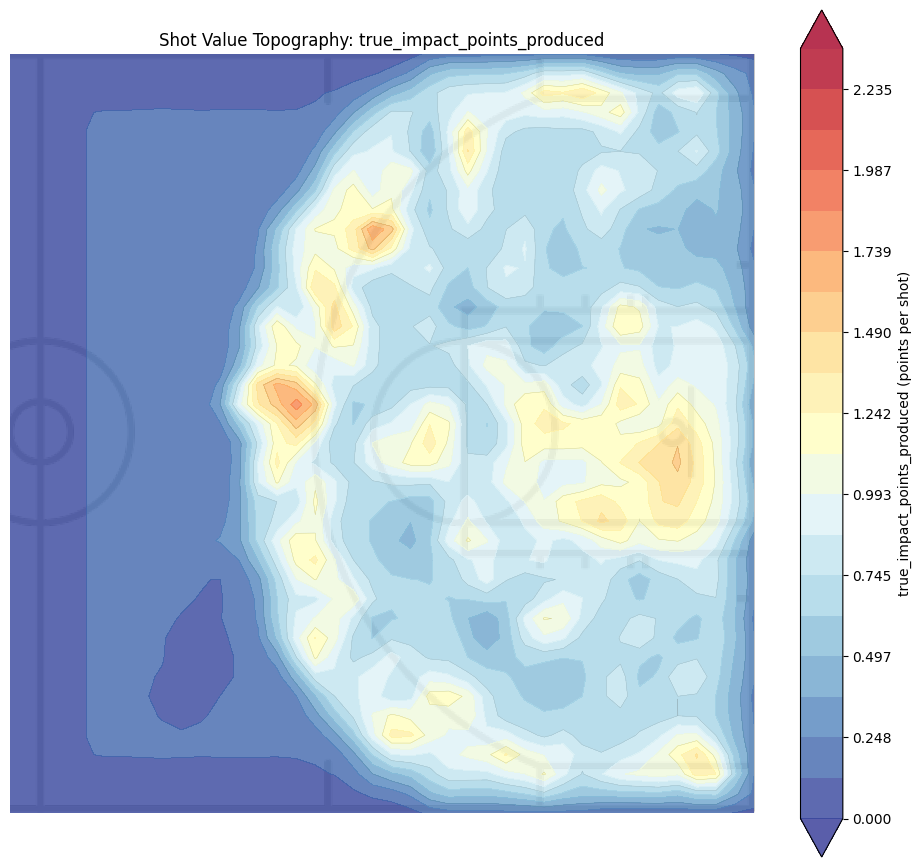

2070 2149
Statistics for points_produced:
count    1876.000000
mean        1.102345
std         1.192499
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         3.000000
Name: points_produced, dtype: float64


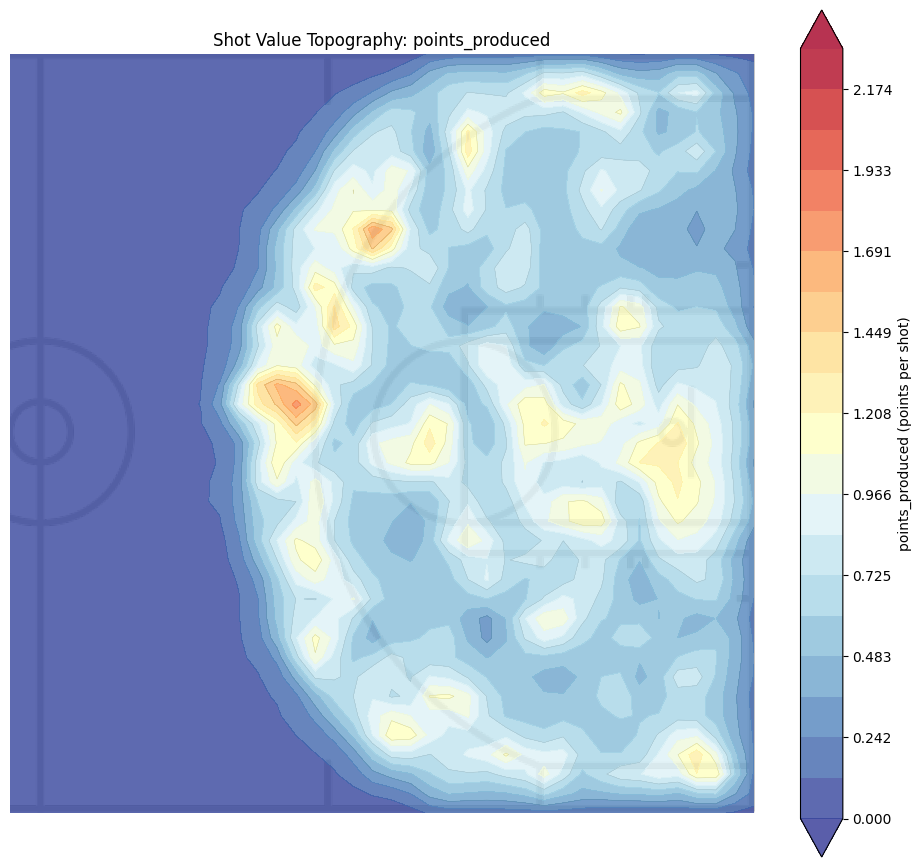

Statistics for true_points_produced:
count    1876.000000
mean        1.143923
std         1.201142
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: true_points_produced, dtype: float64


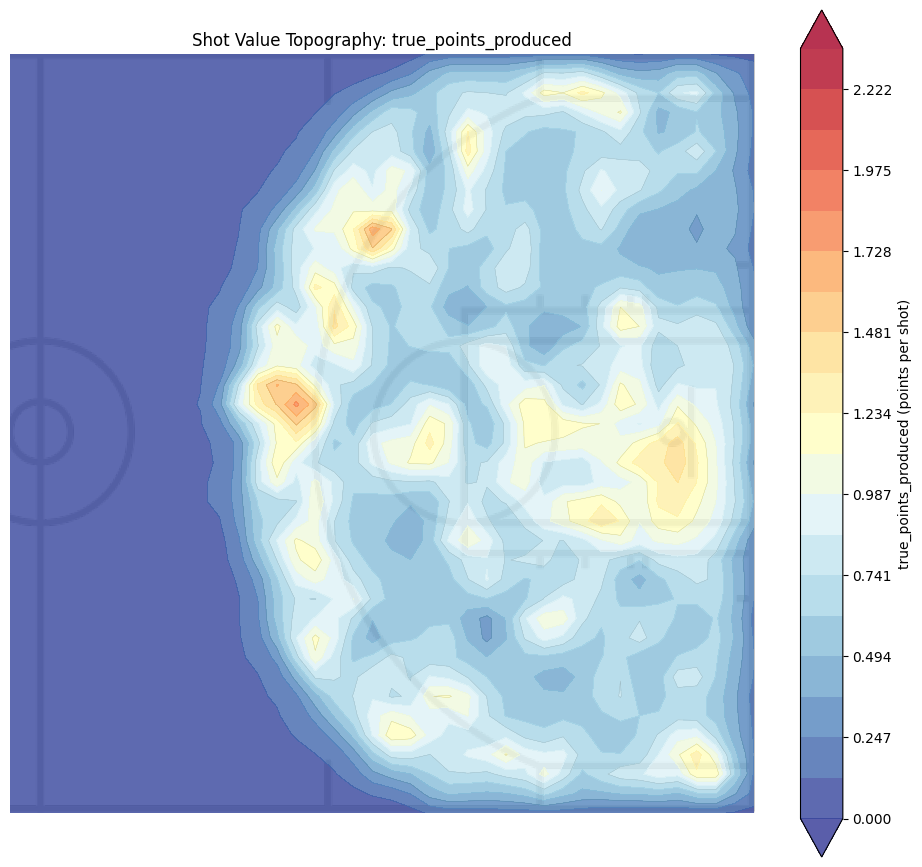

Statistics for net_value:
count    1876.000000
mean        0.158945
std         0.263497
min         0.000000
25%         0.000000
50%         0.030245
75%         0.243172
max         3.000000
Name: net_value, dtype: float64


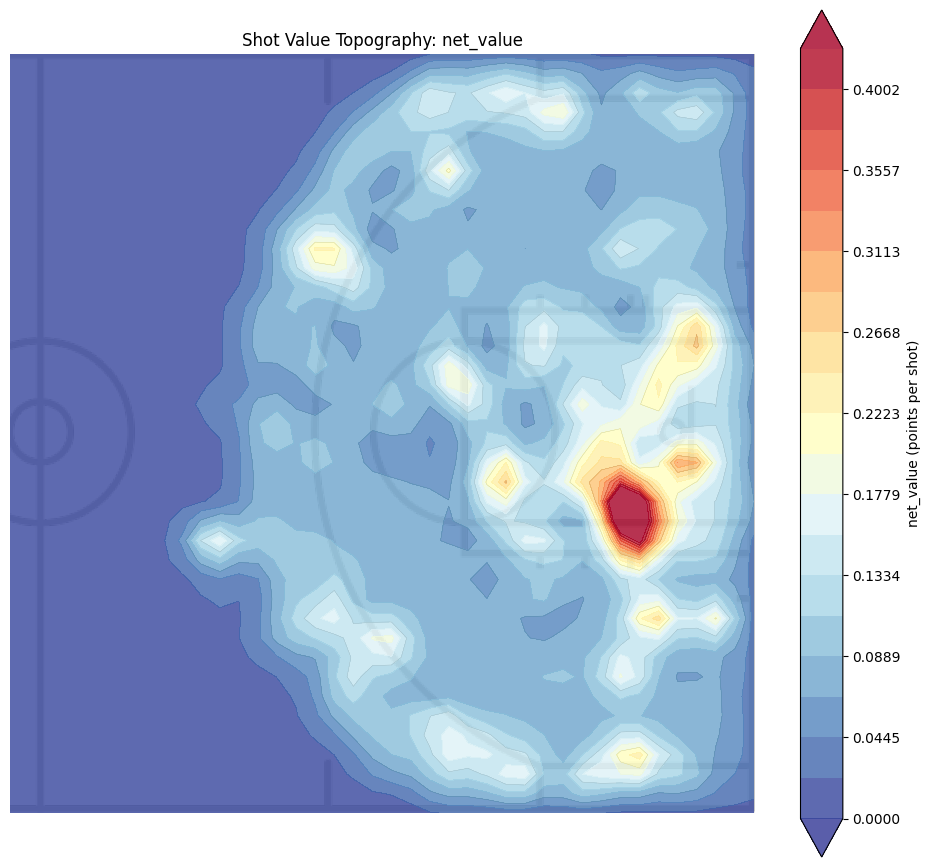

array([[3.31646412e-05, 3.95316341e-04, 1.50290920e-03, ...,
        1.50738125e-02, 1.32447781e-02, 1.14206438e-02],
       [9.15092688e-05, 1.10575582e-03, 4.34904093e-03, ...,
        4.24296784e-02, 3.45232514e-02, 2.65787640e-02],
       [1.26490807e-04, 1.55035703e-03, 6.30705543e-03, ...,
        5.88169239e-02, 4.43993220e-02, 2.81758774e-02],
       ...,
       [1.26490807e-04, 1.55035703e-03, 6.30705543e-03, ...,
        9.99584032e-02, 6.29715753e-02, 2.99792612e-02],
       [9.15092688e-05, 1.10575582e-03, 4.34904093e-03, ...,
        5.65490956e-02, 4.25813010e-02, 2.73955041e-02],
       [3.31646412e-05, 3.95316341e-04, 1.50290920e-03, ...,
        1.63604285e-02, 1.40246143e-02, 1.15004199e-02]])

In [13]:
import pandas as pd
event_df = EventProcessor.load_games()
tracking_df = TrackingProcessor.load_games()
possession_df = PossessionProcessor.load_games()

# First, we need to extract all the shot events, link the corresponding rebound event, and associate with coordinate data
shot_rebound_df = ActionProcessor.extract_shots_and_rebounds(event_df, tracking_df)
print(shot_rebound_df)
# Now that we have the shot/rebounds collected, we can use our FeatureUtil to engineer the regions, shots are classified by which polygon contains them
shot_rebound_classified_df = FeatureUtil.classify_shot_locations(shot_rebound_df, possession_df, FeatureUtil.classify_shot_region)
true_impact_points_df = pd.read_csv('./test3.csv')
print(shot_rebound_classified_df)
print(true_impact_points_df)
shot_rebound_classified_df = shot_rebound_classified_df.rename(columns={"shot_time": "wcTime"})
shot_rebound_classified_df['playerId'] = shot_rebound_classified_df['playerId'].astype(pd.Int64Dtype())
shot_rebound_classified_df['gameId'] = shot_rebound_classified_df['gameId'].astype(pd.Int64Dtype())

shot_rebound_classified_df = shot_rebound_classified_df.merge(
    true_impact_points_df[['gameId', 'playerName', 'wcTime', 'points_produced', 'true_points_produced', 'expected_oreb_points', 'true_impact_points_produced']],
    on=['gameId', 'playerName', 'wcTime'],
    how='left'
)
print(shot_rebound_classified_df)
shot_rebound_classified_df.to_csv('./wtf.csv')


# Plot topographical heatmap using true impact points produced
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="true_impact_points_produced", grid_density=40)

print(shot_rebound_classified_df['points_produced'].sum(), shot_rebound_classified_df['true_points_produced'].sum())

# Plot topographical heatmap using points produced
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="points_produced", grid_density=40)

# Plot topographical heatmap using true points produced
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="true_points_produced", grid_density=40)

# Calculate net value
shot_rebound_classified_df['net_value'] = shot_rebound_classified_df['true_impact_points_produced'] - shot_rebound_classified_df['points_produced']

# Plot topographical heatmap of net value
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="net_value", grid_density=40)

          gameId eventType playerId          playerName      teamId teamAbbr  \
0     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
1     0022300451      SHOT   203944       Julius Randle  1610612752      NYK   
2     0022300451      SHOT  1626157  Karl-Anthony Towns  1610612750      MIN   
3     0022300451      SHOT  1630183     Jaden McDaniels  1610612750      MIN   
4     0022300451      SHOT  1628384          OG Anunoby  1610612752      NYK   
...          ...       ...      ...                 ...         ...      ...   
1872  0022300869      SHOT      NaN       Rui Hachimura  1610612747      LAL   
1873  0022300869      SHOT      NaN       Anthony Davis  1610612747      LAL   
1874  0022300869      SHOT      NaN        LeBron James  1610612747      LAL   
1875  0022300869      SHOT      NaN        Jamal Murray  1610612743      DEN   
1876  0022300869      SHOT      NaN       Austin Reaves  1610612747      LAL   

      period      shot_time  wcTimeEnd 

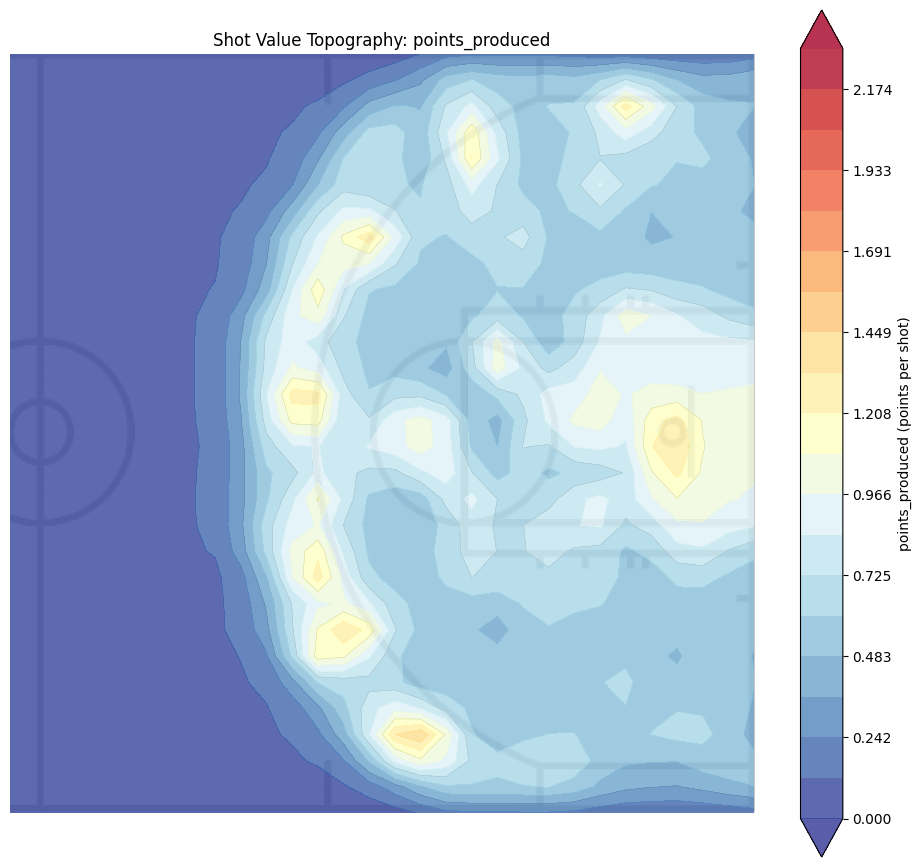

Statistics for true_points_produced:
count    1876.000000
mean        1.143923
std         1.201142
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: true_points_produced, dtype: float64


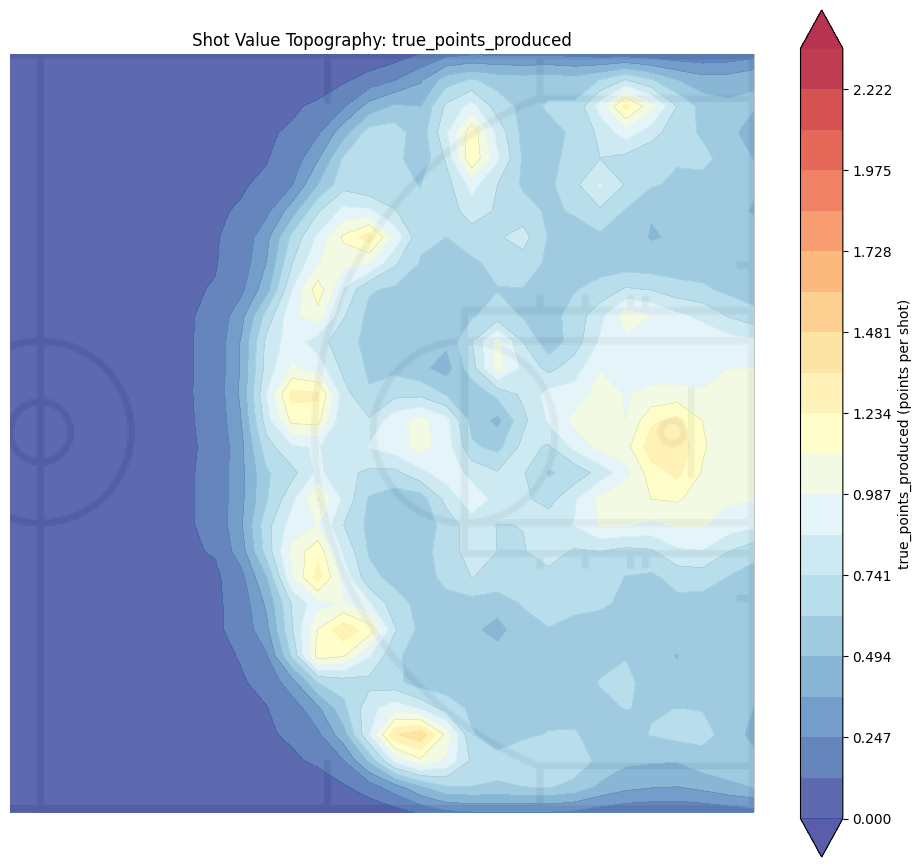

array([[6.27724549e-04, 6.94331491e-03, 2.11732567e-02, 2.85815949e-02,
        2.97093375e-02, 2.98465656e-02, 2.99464030e-02, 2.98475644e-02,
        2.97721099e-02, 2.97642612e-02, 2.97641425e-02, 2.97692124e-02,
        2.99432321e-02, 3.18064458e-02, 3.96429097e-02, 6.85402482e-02,
        1.37743713e-01, 2.08830478e-01, 2.31986135e-01, 2.33092018e-01,
        2.34271744e-01, 2.33998416e-01, 2.17532772e-01, 1.78378237e-01,
        1.52778757e-01, 1.45411356e-01, 1.43909482e-01, 1.49106446e-01,
        1.66788808e-01, 1.96430655e-01],
       [1.70905337e-03, 1.89362482e-02, 5.80819704e-02, 7.91629339e-02,
        8.26476697e-02, 8.30067341e-02, 8.32074197e-02, 8.30102659e-02,
        8.28597563e-02, 8.28441435e-02, 8.28481776e-02, 8.30150779e-02,
        8.59843436e-02, 1.09474590e-01, 1.85392980e-01, 3.18004722e-01,
        4.83708225e-01, 6.06308383e-01, 6.13864639e-01, 6.03313416e-01,
        6.16762011e-01, 6.26055490e-01, 5.80117615e-01, 4.72809940e-01,
        4.05712339e-01,

In [12]:
import pandas as pd

true_impact_points_df = pd.read_csv('./test3.csv')
print(shot_rebound_classified_df)
print(true_impact_points_df)
shot_rebound_classified_df = shot_rebound_classified_df.rename(columns={"shot_time": "wcTime"})
shot_rebound_classified_df['playerId'] = shot_rebound_classified_df['playerId'].astype(pd.Int64Dtype())
shot_rebound_classified_df['gameId'] = shot_rebound_classified_df['gameId'].astype(pd.Int64Dtype())

shot_rebound_classified_df = shot_rebound_classified_df.merge(
    true_impact_points_df[['gameId', 'playerName', 'wcTime', 'points_produced', 'true_points_produced', 'expected_oreb_points', 'true_impact_points_produced']],
    on=['gameId', 'playerName', 'wcTime'],
    how='left'
)
print(shot_rebound_classified_df)
shot_rebound_classified_df.to_csv('./wtf.csv')
# # Plot topographical heatmap using true impact points produced
# VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="true_impact_points_produced")

print(shot_rebound_classified_df['points_produced'].sum(), shot_rebound_classified_df['true_points_produced'].sum())

# Plot topographical heatmap using points produced
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="points_produced", grid_density=30)

# Plot topographical heatmap using true points produced
VisUtil.plot_topographical_heatmap(shot_rebound_classified_df, weight_col="true_points_produced", grid_density=30)